# Time series analysis with HyP3 and MintPy

This notebook walks through performing a time-series analysis of the 2019 Ridgecrest, CA earthquake with On Demand InSAR products from the Alaska Satellite facility and MintPy. We'll:

1. Use the [ASF Search Python package](https://docs.asf.alaska.edu/asf_search/basics/) to:
   - Search ASF's catalog for Sentinel-1 SAR products covering the [Ridgecrest earthquake](https://earthquake.usgs.gov/storymap/index-ridgecrest.html)
   - Select a reference scene to generate a baseline stack
   - Select a [short baseline subset (SBAS)](https://docs.asf.alaska.edu/vertex/sbas/) of scene pairs for InSAR processing


2. Use the [HyP3 Python SDK](https://hyp3-docs.asf.alaska.edu/using/sdk/) to:
   - Request On Demand InSAR products from ASF HyP3
   - Download the InSAR products when they are done processing


3. Use [GDAL](https://gdal.org/api/index.html#python-api) and [MintPy](https://mintpy.readthedocs.io/en/latest/) to:
   - Prepare the InSAR products for MintPy
   - perform a time-series analysis with MintPy
   
---

**Note:** This notebook does assume you have some familiarity with InSAR processing with MintPy already, and is a minimal example without much context or explanations. If you're new to InSAR and MintPy, I suggest checking out:
* our [InSAR on Demand Story Map](https://storymaps.arcgis.com/stories/68a8a3253900411185ae9eb6bb5283d3)


* [OpenSARlab's](https://opensarlab-docs.asf.alaska.edu/) highly detailed walkthrough of using HyP3 + MintPy via these notebooks:
  * [Prepare a HyP3 InSAR Stack for MintPy](https://nbviewer.org/github/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/Prepare_HyP3_InSAR_Stack_for_MintPy.ipynb)
  * [MintPy Time-series Analysis](https://nbviewer.org/github/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/MintPy_Time_Series_From_Prepared_Data_Stack.ipynb)
  
    Note: While these notebooks make some assumptions you're working in OpenSARlab, you can run these 
    notebooks outside OpenSARlab by creating [this conda environment](https://github.com/ASFOpenSARlab/opensarlab-envs/blob/main/Environment_Configs/insar_analysis_env.yml).

## 0. Initial Setup

To run this notebook, you'll need a conda environment with the required dependencies. You can set up a new environment (recommended) and run the jupyter server like:

```bash
mamba create -n hyp3-mintpy python>=3.11 asf_search hyp3_sdk "mintpy>=1.5.2" pandas jupyter ipympl pystac tifffile fsspec aiohttp h5py netcdf4 odc-stac gdal leafmap localtileserver

mamba activate hyp3-mintpy

jupyter lab
```

### Set parameters

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from dateutil.parser import parse as parse_date

project_name = '2019_ridgecrest_march'
work_dir = Path.cwd() / project_name
stac_dir = work_dir / 'stac'

stack_start = parse_date('2019-06-10 00:00:00Z')
stack_end = parse_date('2019-07-21 00:00:00Z')
max_temporal_baseline = 13  # days

work_dir.mkdir(parents=True, exist_ok=True)

## 1. Select InSAR pairs with ASF Search

In [ ]:
import asf_search as asf
import pandas as pd

search_results = asf.geo_search(
    platform=asf.PLATFORM.SENTINEL1,
    intersectsWith='POINT(-117.599330 35.769500)',
    start='2019-06-10',
    end='2019-07-21',
    processingLevel=asf.PRODUCT_TYPE.SLC,
    beamMode=asf.BEAMMODE.IW,
    flightDirection=asf.FLIGHT_DIRECTION.ASCENDING,
)

In [ ]:
baseline_results = asf.baseline_search.stack_from_product(search_results[-1])

columns = list(baseline_results[0].properties.keys()) + ['geometry']
data = [list(scene.properties.values()) + [scene.geometry] for scene in baseline_results]

stack = pd.DataFrame(data, columns=columns)
stack['startTime'] = stack.startTime.apply(parse_date)

stack = stack.loc[(stack_start <= stack.startTime) & (stack.startTime <= stack_end)]

In [ ]:
sbas_pairs = set()

for reference, rt in stack.loc[::-1, ['sceneName', 'temporalBaseline']].itertuples(index=False):
    secondaries = stack.loc[
        (stack.sceneName != reference) & (stack.temporalBaseline - rt <= max_temporal_baseline) & (stack.temporalBaseline - rt > 0)
    ]
    for secondary in secondaries.sceneName:
        sbas_pairs.add((reference, secondary))

## 2. Request On Demand InSAR products from ASF HyP3

Use your [NASA Earthdata login](https://urs.earthdata.nasa.gov/) to connect to [ASF HyP3](https://hyp3-docs.asf.alaska.edu/).

In [3]:
import hyp3_sdk as sdk

hyp3 = sdk.HyP3()

In [ ]:
jobs = sdk.Batch()
for reference, secondary in sbas_pairs:
    jobs += hyp3.submit_insar_job(reference, secondary, name=project_name, include_dem=True, include_look_vectors=True)

In [ ]:
jobs = hyp3.watch(jobs)

In [4]:
jobs = hyp3.find_jobs(name=project_name).filter_jobs(succeeded=True, include_expired=False)

In [6]:
from hyp3_sdk.stac import stac

stac.create_stac_collection(jobs, stac_dir)

/Users/ffwilliams2/Repositories/hyp3/hyp3-sdk/src/hyp3_sdk/stac/stac.py:19: FutureWarning: This submodule is under rapid development. STAC item (not collection) creation will eventually move to hyp3-lib.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.93it/s]


## 3. View Data

In [7]:
import pystac
from hyp3_sdk.stac import load


collection = pystac.Collection.from_file(stac_dir / 'collection.json')
items = list(collection.get_all_items())
dataset = load.create_xarray_dataset(items)

In [8]:
dataset

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 11, y: 3509, x: 3743)
Coordinates:
  * y            (y) float64 28kB 4.143e+06 4.143e+06 ... 3.862e+06 3.862e+06
  * x            (x) float64 30kB 2.7e+05 2.701e+05 ... 5.693e+05 5.694e+05
    spatial_ref  int32 4B 32611
  * time         (time) datetime64[ns] 88B 2019-06-13T01:50:22.500000 ... 201...
Data variables:
    corr         (time, y, x) float32 578MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    unw_phase    (time, y, x) float32 578MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    lv_phi       (time, y, x) float32 578MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    lv_theta     (time, y, x) float32 578MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    dem          (time, y, x) float32 578MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    water_mask   (time, y, x) float32 578MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

### 3.1 Select a bounding box
We'll select our MintPy bounding box by drawing it on this unwrapped interferogram image. Use the "Draw a rectangle" tool to draw a rectangle covering the area you'd like to process with MintPy.

In [9]:
%%time

eq_ds = dataset.isel(time=7)['unw_phase']
eq_ds = eq_ds.load()

CPU times: user 1.22 s, sys: 360 ms, total: 1.58 s
Wall time: 11 s


In [10]:
import leafmap

transform = [float(x) for x in eq_ds.spatial_ref.attrs['GeoTransform'].split(' ')]
proj_transform = [transform[1],transform[2],transform[0],transform[4],transform[5],transform[3]]

m = leafmap.Map()
unw_image = leafmap.array_to_image(eq_ds.to_numpy(), cellsize=transform[1], crs=f'EPSG:{dataset.spatial_ref.item()}', transform=proj_transform)
m.add_raster(unw_image, colormap='coolwarm', layer_name='Unwrap')
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [11]:
from pyproj.transformer import Transformer
from shapely.geometry import Polygon, shape


def get_bbox(map, epsg):
    features = m.draw_features
    if len(features) > 1:
        raise ValueError('Only 1 feature can be used. Remove all features from map and start again.')
    polygon = Polygon(shape(features[0]['geometry']))
    minx, miny, maxx, maxy = polygon.bounds
    transformer = Transformer.from_crs('EPSG:4326', f'EPSG:{epsg}', always_xy=True)
    (minx, maxx), (miny, maxy) = transformer.transform([minx, maxx], [miny, maxy])
    return [round(coord) for coord in (minx, maxx, miny, maxy)]

In [12]:
# sample_bbox = [408800,487300,3918900,3987200]
get_bbox(m, dataset.spatial_ref.item())

[413448, 485351, 3922273, 3987146]

## 4. Run MintPy time series analysis

In [13]:
%%time
from hyp3_sdk.stac import load

load.create_mintpy_inputs(stac_dir / 'collection.json', subset_geo=get_bbox(m, dataset.spatial_ref.item()), mintpy_dir=work_dir)

Creating interferogram stack...
Creating geometry dataset...
Done!
CPU times: user 7.31 s, sys: 1.13 s, total: 8.44 s
Wall time: 23.8 s


In [14]:
mintpy_config = work_dir / 'mintpy_config.cfg'
mintpy_config.write_text(f"""
mintpy.load.processor = hyp3
##---------misc:
mintpy.plot = no
mintpy.network.coherenceBased = no
mintpy.troposphericDelay.method = no
mintpy.reference.date = 20190610
""")

169

In [15]:
!smallbaselineApp.py --dir {work_dir} --start modify_network {mintpy_config}


___________________________________________________________

  /##      /## /##             /##     /#######
 | ###    /###|__/            | ##    | ##__  ##
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/
          MintPy 1.5.3.post25, 2024-03-05
___________________________________________________________

--RUN-at-2024-03-11 16:15:38.131494--
Current directory: /Users/ffwilliams2/Data/mintpy
Run routine processing with smallbaselineApp.py on steps: ['modify_network', 'reference_point', 'quick_overview', 'corre

In [16]:
%matplotlib widget
import matplotlib.pyplot as plt
from mintpy.cli import view, tsview

run view.py in MintPy version 1.5.3.post25, date 2024-03-05
input file is velocity file: /Users/ffwilliams2/Data/mintpy/2019_ridgecrest_march/velocity.h5 in float32 format
file size in y/x: (811, 899)
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (5):
['velocity', 'velocityStd', 'intercept', 'interceptStd', 'residue']
data   coverage in y/x: (0, 0, 899, 811)
subset coverage in y/x: (0, 0, 899, 811)
data   coverage in lat/lon: (413480.0, 3987080.0, 485400.0, 3922200.0)
subset coverage in lat/lon: (413480.0, 3987080.0, 485400.0, 3922200.0)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [15.00, 8.00]
dataset number: 5
row     number: 2
column  number: 3
figure  number: 1
read mask from file: maskTempCoh.h5
----------------------------------------
Figure 1 - velocity.png
reading data as a list of 2D matrices ...
[==================================================] residuept

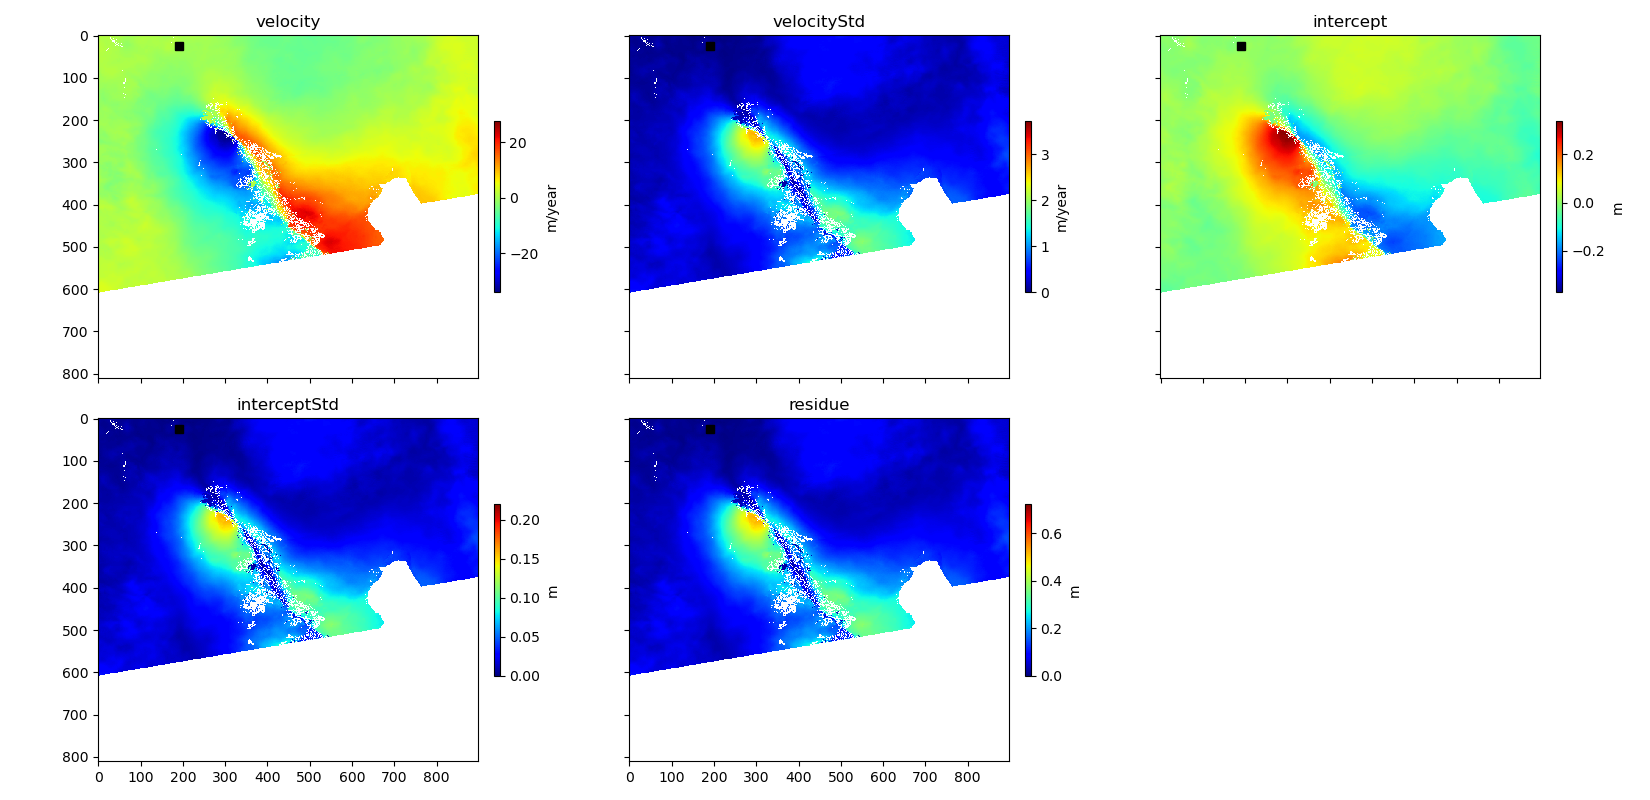

In [17]:
view.main([f'{work_dir}/velocity.h5'])

tsview.py /Users/ffwilliams2/Data/mintpy/2019_ridgecrest_march/timeseries.h5
open timeseries file: timeseries.h5
No lookup table (longitude or rangeCoord) found in files.
data   coverage in y/x: (0, 0, 899, 811)
subset coverage in y/x: (0, 0, 899, 811)
data   coverage in lat/lon: (413480.0, 3987080.0, 485400.0, 3922200.0)
subset coverage in lat/lon: (413480.0, 3987080.0, 485400.0, 3922200.0)
------------------------------------------------------------------------
reference point in y/x: (24, 191)
reference point in lat/lon: (3985120.0, 428800.0)
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    polyline   : []
    exp        : {}
    log        : {}
reading timeseries from file /Users/ffwilliams2/Data/mintpy/2019_ridgecrest_march/timeseries.h5
reference to date: 20190610
read mask from file: maskTempCoh.h5
data    range: [-54.917793, 79.165306] cm
display range: [-53.4424, 76.683655] cm
create figure for

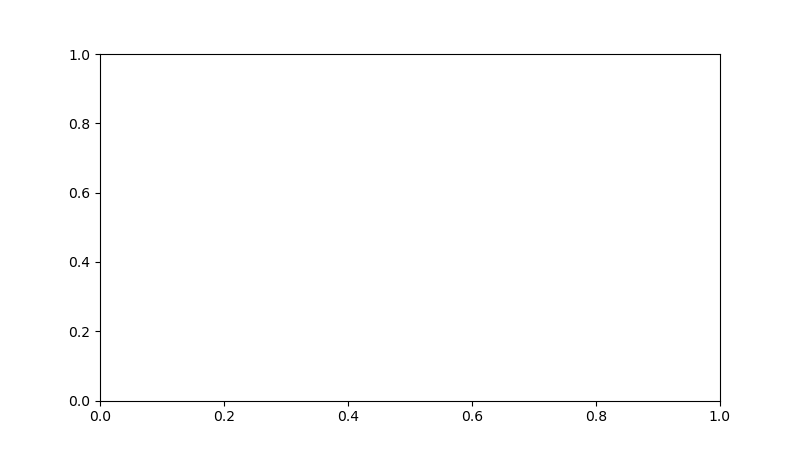

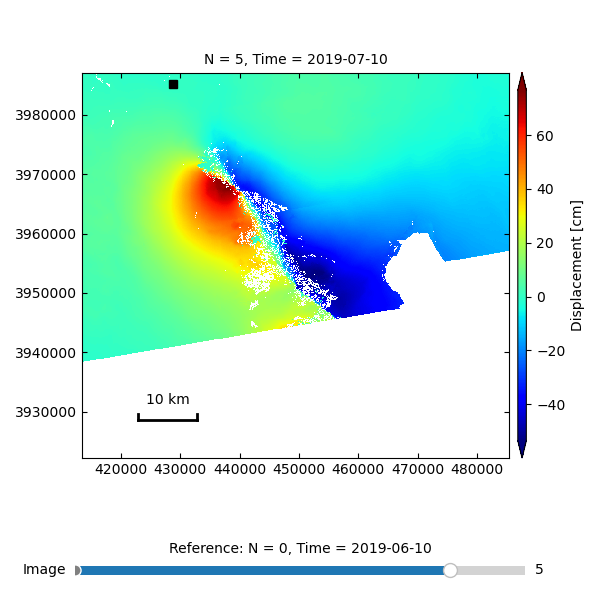

In [18]:
tsview.main([f'{work_dir}/timeseries.h5'])